In [293]:
from foragax.base.agent_classes import *
from foragax.base.agent_methods import *
from foragax.base.space_classes import *
from foragax.base.space_methods import *
from foragax.policy.wilson_cowan import *
import foragax.base.space_methods as sm

In [294]:
from flax.training import orbax_utils
import orbax

import jax
import jax.numpy as jnp
from flax import struct

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import jax.numpy as jnp
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)
from matplotlib import animation

In [296]:
@struct.dataclass
class Forager(Agent):
    @staticmethod
    def create_agent(params: Params, unique_id: int, active_state: int, agent_type:int, key: jax.random.PRNGKey):
        key, policy_key = jax.random.split(key)
        policy_params = Params(content=params.content['policy_params'])
        policy = WilsonCowan.create_policy(policy_params, policy_key)
        
        params_content = {'dt': params.content['dt']}
        agent_params = Params(content=params_content)

        def create_active_agent(key, params):

            key, *keys = jax.random.split(key, 8)
            space = params.content['space']
            X = jax.random.uniform(keys[0], (1,), minval=space.x_min + (space.x_min+1.0)/10.0, maxval=space.x_max - space.x_max/10.0)
            X_vel = jax.random.uniform(keys[1], (1,), minval=-1.0, maxval=1.0)
            X_acc = jax.random.uniform(keys[2], (1,), minval=-1.0, maxval=1.0)
            
            Y = jax.random.uniform(keys[3], (1,), minval=space.y_min + (space.y_min+1.0)/10.0, maxval=space.y_max - space.y_max/10.0)
            Y_vel = jax.random.uniform(keys[4], (1,), minval=-1.0, maxval=1.0)
            Y_acc = jax.random.uniform(keys[5], (1,), minval=-1.0, maxval=1.0)
            
            ang = jnp.arctan2(Y_vel, X_vel) 

            energy = jax.random.uniform(keys[6], (1,), minval=5.0, maxval=10.0)
            rad = energy

            time_above_rep_thresh = jnp.zeros(1)
            time_below_die_thresh = jnp.zeros(1)

            state_content = {'X': X, 'X_vel': X_vel, 'X_acc': X_acc, 'Y': Y, 'Y_vel': Y_vel, 'Y_acc': Y_acc, 'ang':ang,
                             'energy': energy, 'rad': rad, 'time_above_rep_thresh': time_above_rep_thresh, 
                             'time_below_die_thresh': time_below_die_thresh}
            
            return State(content=state_content)
        
        def create_inactive_agent():
            state_content = {'X': jnp.array([-1.0]), 'X_vel': jnp.zeros(1), 'X_acc': jnp.zeros(1), 'Y': jnp.array([-1.0]),
                             'Y_vel': jnp.zeros(1), 'Y_acc': jnp.zeros(1), 'ang': jnp.zeros(1),
                             'energy': jnp.array([-1.0]), 'rad': jnp.zeros(1),
                             'time_above_rep_thresh': jnp.array([-1.0]), 'time_below_die_thresh': jnp.array([-1.0])}
            return State(content=state_content)
        
        agent_state = jax.lax.cond(active_state, lambda _: create_active_agent(key, params),
                                      lambda _: create_inactive_agent(), None)
        return Forager(state=agent_state, policy=policy, params=agent_params, unique_id=unique_id, 
                       agent_type=agent_type, age = 0.0, active_state=active_state)
    
    @staticmethod
    def step_agent(params:Params, input:Signal, forager:Agent):
        def step_active_agent(params, input, forager):
            
            space = params.content['space']
            
            energy_in = input.content['energy_in']
            obs_content = input.content['obs']
            obs_content = jnp.concatenate((obs_content, forager.state.content['energy']))
            obs = Signal(content={'obs': obs_content})
            
            actions, new_policy = WilsonCowan.step_policy(obs, forager.policy)

            X_acc = jnp.array([actions.content['actions'][0]])
            Y_acc = jnp.array([actions.content['actions'][1]])

            X_pos = forager.state.content['X']
            Y_pos = forager.state.content['Y']
            X_vel = forager.state.content['X_vel']
            Y_vel = forager.state.content['Y_vel']

            dt = forager.params.content['dt']
            X_pos_new = X_pos + X_vel*dt
            Y_pos_new = Y_pos + Y_vel*dt
            X_vel_new = X_vel + X_acc*dt
            Y_vel_new = Y_vel + Y_acc*dt

            X_pos_new, X_vel_new = jax.lax.cond(jnp.logical_or(X_pos_new[0] > space.x_max, X_pos_new[0] < space.x_min),
                                                 lambda _: (X_pos, -X_vel), lambda _: (X_pos_new, X_vel_new), None)
            
            Y_pos_new, Y_vel_new = jax.lax.cond(jnp.logical_or(Y_pos_new[0] > space.y_max, Y_pos_new[0] < space.y_min),
                                                lambda _: (Y_pos, -Y_vel), lambda _: (Y_pos_new, Y_vel_new), None)
            
            ang_new = jnp.arctan2(Y_vel_new, X_vel_new)

            energy = forager.state.content['energy']
            energy_new = energy + energy_in - dt*jnp.sum(jnp.abs(actions.content['actions']))
            energy_new = jnp.minimum(energy_new, params.content['energy_max'])
            rad_new = energy_new

            time_above_rep_thresh = forager.state.content['time_above_rep_thresh']
            time_above_rep_thresh_new = jax.lax.cond(energy_new[0] > params.content['repr_thresh'],
                                                    lambda _: time_above_rep_thresh + dt, 
                                                    lambda _: jnp.zeros(1), None)
            
            time_below_die_thresh = forager.state.content['time_below_die_thresh']
            time_below_die_thresh_new = jax.lax.cond(energy_new[0] < params.content['die_thresh'],
                                                      lambda _: time_below_die_thresh + dt, lambda _: jnp.zeros(1), None)
            
            new_state_content = {'X': X_pos_new, 'X_vel': X_vel_new, 'X_acc': X_acc, 'Y': Y_pos_new, 'Y_vel': Y_vel_new,
                                 'Y_acc': Y_acc, 'ang': ang_new, 'energy': energy_new, 'rad': rad_new,
                                 'time_above_rep_thresh': time_above_rep_thresh_new, 'time_below_die_thresh': time_below_die_thresh_new}
            
            new_state = State(content = new_state_content)
            new_forager = forager.replace(state=new_state, policy=new_policy, age=forager.age+dt)
            return new_forager
        
        def step_inactive_agent():
            return forager
        
        new_forager = jax.lax.cond(forager.active_state, lambda _: step_active_agent(params, input, forager),
                                   lambda _: step_inactive_agent(), None)
        return new_forager
    
    @staticmethod
    def remove_agent(params:Params, foragers:Agent, idx):
        forager_to_remove = jax.tree_util.tree_map(lambda x: x[idx], foragers)
        state_content = {'X': jnp.array([-1.0]), 'X_vel': jnp.zeros(1), 'X_acc': jnp.zeros(1), 'Y': jnp.array([-1.0]),
                            'Y_vel': jnp.zeros(1), 'Y_acc': jnp.zeros(1), 'ang': jnp.array([-1.0]), 'energy': jnp.array([-1.0]),
                            'rad': jnp.zeros(1), 'time_above_rep_thresh': jnp.array([-1.0]), 'time_below_die_thresh': jnp.array([-1.0])}
        new_state = State(content=state_content)
        
        policy_state_content = {'Z': jnp.zeros_like(forager_to_remove.policy.state.content['Z'])}
        new_policy_state = State(content=policy_state_content)
        new_policy = forager_to_remove.policy.replace(state=new_policy_state)

        dead_forager = forager_to_remove.replace(state = new_state, policy = new_policy, active_state = False, age = 0.0)
        return dead_forager
    
    @staticmethod
    def add_agent(params:Params, foragers:Agent, idx, key):
        good_ids = params.content['good_ids']
        num_active_foragers = params.content['num_active_foragers']
        forager_to_add = jax.tree_util.tree_map(lambda x: x[idx], foragers)
        forager_to_copy = jax.tree_util.tree_map(lambda x: x[good_ids[idx - num_active_foragers]], foragers)
        
        X = forager_to_copy.state.content['X']
        X_vel = jnp.zeros(1)
        X_acc = jnp.zeros(1)
        
        Y = forager_to_copy.state.content['Y']
        Y_vel = jnp.zeros(1)
        Y_acc = jnp.zeros(1)
        
        ang = jnp.zeros(1)
        energy = forager_to_copy.state.content['energy']/2.0
        rad = energy
        
        time_above_rep_thresh = jnp.zeros(1)
        time_below_die_thresh = jnp.zeros(1)
        state = State(content={'X': X, 'X_vel': X_vel, 'X_acc': X_acc, 'Y': Y, 'Y_vel': Y_vel, 'Y_acc': Y_acc, 'ang': ang,
                               'energy': energy, 'rad': rad, 'time_above_rep_thresh': time_above_rep_thresh,
                               'time_below_die_thresh': time_below_die_thresh})

        noise_scale = 0.1/(forager_to_copy.age + 0.01)
        noise_scale = jnp.clip(noise_scale, 0.001, 0.1)
        key, *noise_keys = jax.random.split(key, 6)
        J = forager_to_copy.policy.params.content['J']
        J_noise = jax.random.normal(noise_keys[0], J.shape)
        new_J = J + noise_scale * J_noise

        tau = forager_to_copy.policy.params.content['tau']
        tau_noise = jax.random.normal(noise_keys[1], tau.shape)
        new_tau = tau + noise_scale * tau_noise

        E = forager_to_copy.policy.params.content['E']
        E_noise = jax.random.normal(noise_keys[2], E.shape)
        new_E = E + noise_scale * E_noise

        B = forager_to_copy.policy.params.content['B']
        B_noise = jax.random.normal(noise_keys[3], B.shape)
        new_B = B + noise_scale * B_noise

        D = forager_to_copy.policy.params.content['D']
        D_noise = jax.random.normal(noise_keys[4], D.shape)
        new_D = D + noise_scale * D_noise

        policy_params_content = {'J': new_J, 'tau': new_tau, 'E': new_E, 'B': new_B, 'D': new_D, 
                                 'dt': forager_to_add.policy.params.content['dt'], 'action_scale' : forager_to_add.policy.params.content['action_scale']}
        policy_params = Params(content=policy_params_content)

        policy = forager_to_add.policy.replace(params=policy_params)

        active_state = True
        new_forager = forager_to_add.replace(state=state, policy=policy, age=0.0, active_state=active_state)
        return new_forager, key
    
    @staticmethod
    def set_agent(params:Params, foragers:Agent, idx, key):
        forager_to_set = jax.tree_util.tree_map(lambda x: x[idx], foragers)
        energy = forager_to_set.state.content['energy']
        energy_new = energy/2.0
        time_above_rep_thresh = jnp.zeros(1)
        new_state_content = {'X': forager_to_set.state.content['X'], 'X_vel': forager_to_set.state.content['X_vel'],
                             'X_acc': forager_to_set.state.content['X_acc'], 'Y': forager_to_set.state.content['Y'],
                             'Y_vel': forager_to_set.state.content['Y_vel'], 'Y_acc': forager_to_set.state.content['Y_acc'],
                             'ang': forager_to_set.state.content['ang'], 'energy': energy_new, 'rad': energy_new,
                             'time_above_rep_thresh': time_above_rep_thresh, 'time_below_die_thresh': forager_to_set.state.content['time_below_die_thresh']}
        new_state = State(content=new_state_content)
        new_forager = forager_to_set.replace(state=new_state)
        return new_forager, key


In [297]:
@struct.dataclass
class Resource(Agent):
    @staticmethod
    def create_agent(params: Params, unique_id: int, active_state: int, agent_type:int, key: jax.random.PRNGKey):
        policy = None
        
        key, param_key = jax.random.split(key)
        growth_rate = jax.random.uniform(param_key, (1,), minval=0.01, maxval=1.0)
        decay_rate = 0.2*growth_rate
        x_min = params.content['space'].x_min
        x_max = params.content['space'].x_max
        y_min = params.content['space'].y_min
        y_max = params.content['space'].y_max
        params_content = {'growth_rate': growth_rate, 'decay_rate': decay_rate, 'dt': params.content['dt'], 
                          'x_min': x_min, 'x_max': x_max, 'y_min': y_min, 'y_max': y_max}
        agent_params = Params(content=params_content)

        def create_active_agent(params, key):
            space = params.content['space']
            key, *state_keys = jax.random.split(key, 4)
            X = jax.random.uniform(state_keys[0], (1,), minval=space.x_min + (space.x_min+1.0)/10.0, maxval=space.x_max - space.x_max/10.0)
            Y = jax.random.uniform(state_keys[1], (1,), minval=space.y_min + (space.y_min+1.0)/10.0, maxval=space.y_max - space.y_max/10.0)
            energy = jax.random.uniform(state_keys[2], (1,), minval= 3.0, maxval = 4.0)
            state_content = {'X': X, 'Y': Y, 'energy': energy, 'rad': energy, 'blossom': False, 'key': key, 'time_above_blossom': jnp.zeros(1)}
            return State(content=state_content)
        
        def create_inactive_agent(key):
            state_content = {'X': jnp.array([-1.0]), 'Y': jnp.array([-1.0]), 'energy': jnp.zeros(1), 
                             'rad': jnp.zeros(1), 'blossom': False, 'key': key, 'time_above_blossom': jnp.array([-1.0])}
            return State(content=state_content)
        
        agent_state = jax.lax.cond(active_state, lambda _: create_active_agent(params, key),
                                   lambda _: create_inactive_agent(key), None)
        return Resource(state=agent_state, policy=policy, params=agent_params, unique_id=unique_id, agent_type=agent_type, age=0.0, active_state=active_state)
    
    @staticmethod
    def step_agent(params:Params, input:Signal, res:Agent):
        def step_active_agent(params, input, res):
            dt = res.params.content['dt']
            state = res.state
            old_energy = state.content['energy']
            
            gr = res.params.content['growth_rate']
            dr = res.params.content['decay_rate']
            eaten = input.content['energy_out']
            
            new_energy = old_energy + dt*(gr * old_energy - dr * (old_energy**2)) - eaten
            new_energy = jnp.clip(new_energy, 0.0, 5.0)
            new_rad = new_energy

            x_min = res.params.content['x_min']
            x_max = res.params.content['x_max']
            
            res_x = state.content['X']
            
            blossom_prob = jax.nn.sigmoid(4*(x_max - res_x)/(x_max - x_min))# minimum at x_max, maximum at x_min
            new_key, blossom_key = jax.random.split(state.content['key'])
            new_blossom_luck = jax.random.bernoulli(blossom_key, blossom_prob)

            blossom_change = jax.lax.cond(jnp.logical_and(new_blossom_luck[0], new_energy[0] > params.content['blossom_thresh']),
                                           lambda _: True, lambda _: False, None)
            blossom = jax.lax.cond(res.state.content['blossom'], lambda _: res.state.content['blossom'], lambda _: blossom_change, None)

            time_above_blossom = res.state.content['time_above_blossom']
            time_above_blossom_new = jax.lax.cond(blossom, lambda _: time_above_blossom + dt, lambda _: jnp.zeros(1), None)
            
            new_state_content = {'X': state.content['X'], 'Y': state.content['Y'], 'energy': new_energy, 'rad': new_rad, 'blossom': blossom, 'key': new_key, 'time_above_blossom': time_above_blossom_new}
            state = State(content=new_state_content)

            new_res = res.replace(state=state, age = res.age + dt)
            return new_res
        def step_inactive_agent(res):
            return res
        
        new_res = jax.lax.cond(res.active_state, lambda _: step_active_agent(params, input, res), lambda _: step_inactive_agent(res), None)
        return new_res
    
    @staticmethod
    def remove_agent(remove_params: Params, Agents: Agent, idx):
        agent_to_remove = jax.tree_util.tree_map(lambda x: x[idx], Agents)
        state_content = {'X': jnp.array([-1.0]), 'Y': jnp.array([-1.0]), 'energy': jnp.zeros(1), 'rad': jnp.zeros(1), 'blossom': False, 
                         'key': agent_to_remove.state.content['key'], 'time_above_blossom': jnp.array([-1.0])}
        state = State(content=state_content)
        active_state = False
        new_agent = agent_to_remove.replace(state=state, active_state=active_state, age = 0.0)
        return new_agent
    
    @staticmethod
    def add_agent(params:Params, ress:Agent, idx, key:jax.random.PRNGKey):
        good_ids = params.content['good_ids']
        num_active_resources = params.content['num_active_resources']
        res_to_add = jax.tree_util.tree_map(lambda x: x[idx], ress)
        res_to_copy = jax.tree_util.tree_map(lambda x: x[good_ids[idx - num_active_resources]], ress)
        
        key, *state_keys = jax.random.split(key, 4)
        res_to_copy_rad = res_to_copy.state.content['rad']
        X = res_to_copy.state.content['X'] + jax.random.uniform(state_keys[0], (1,), minval= -2*res_to_copy_rad, maxval=2*res_to_copy_rad)
        X = jnp.clip(X, res_to_copy.params.content['x_min'], res_to_copy.params.content['x_max'])

        Y = res_to_copy.state.content['Y'] + jax.random.uniform(state_keys[1], (1,), minval= -2*res_to_copy_rad, maxval=2*res_to_copy_rad)
        Y = jnp.clip(Y, res_to_copy.params.content['y_min'], res_to_copy.params.content['y_max'])

        energy = jax.random.uniform(state_keys[2], (1,), minval=3.0, maxval=4.0)
        rad = energy
        res_key = res_to_add.state.content['key']
        state = State(content={'X': X, 'Y': Y, 'energy': energy, 'rad': rad, 'blossom': False, 'key': res_key, 'time_above_blossom': jnp.zeros(1)})

        key, param_key = jax.random.split(key)
        gr = res_to_copy.params.content['growth_rate'] + jax.random.uniform(param_key, (1,), minval=-0.01, maxval=0.01)
        gr = jnp.clip(gr, 0.001, 1.0)
        dr = 0.2*gr
        params_content = {'growth_rate': gr, 'decay_rate': dr, 'dt': res_to_copy.params.content['dt'],
                          'x_min': res_to_copy.params.content['x_min'], 'x_max': res_to_copy.params.content['x_max'],
                          'y_min': res_to_copy.params.content['y_min'], 'y_max': res_to_copy.params.content['y_max']}
        
        new_res = res_to_add.replace(state=state, params=Params(content=params_content), age=0.0, active_state=True)
        return new_res, key
    
    @staticmethod
    def set_agent(params:Params, ress:Agent, idx, key):
        res_to_set = jax.tree_util.tree_map(lambda x: x[idx], ress)
        energy = res_to_set.state.content['energy']/2.0
        blossom = False
        new_state_content = {'X': res_to_set.state.content['X'], 'Y': res_to_set.state.content['Y'], 'energy': energy, 
                             'rad': energy, 'blossom': blossom, 'key': res_to_set.state.content['key'], 'time_above_blossom': jnp.zeros(1)}
        new_state = State(content=new_state_content)
        new_res = res_to_set.replace(state=new_state)
        return new_res, key
        

In [298]:
@struct.dataclass
class Rec_Data:
    forager_xs: jnp.ndarray
    forager_ys: jnp.ndarray
    forager_angs: jnp.ndarray
    forager_rads: jnp.ndarray

    resource_xs: jnp.ndarray
    resource_ys: jnp.ndarray
    resource_rads: jnp.ndarray
    resource_blossoms: jnp.ndarray

def init_rec_data(frames:jnp.int32, forager_set:Agent_Set, resource_set:Agent_Set):
    forager_xs = jnp.zeros((frames, forager_set.num_total_agents, 1))
    forager_ys = jnp.zeros((frames, forager_set.num_total_agents, 1))
    forager_angs = jnp.zeros((frames, forager_set.num_total_agents, 1))
    forager_rads = jnp.zeros((frames, forager_set.num_total_agents, 1))

    resource_xs = jnp.zeros((frames, resource_set.num_total_agents, 1))
    resource_ys = jnp.zeros((frames, resource_set.num_total_agents, 1))
    resource_rads = jnp.zeros((frames, resource_set.num_total_agents, 1))
    resource_blossoms = jnp.zeros((frames, resource_set.num_total_agents))

    return Rec_Data(forager_xs=forager_xs, forager_ys=forager_ys, forager_angs=forager_angs, forager_rads=forager_rads,
                    resource_xs=resource_xs, resource_ys=resource_ys, resource_rads=resource_rads, resource_blossoms=resource_blossoms)

def record_data(foragers, resources, rec_data_obj, frame):
    forager_xs = rec_data_obj.forager_xs.at[frame].set(foragers.state.content['X'])
    forager_ys = rec_data_obj.forager_ys.at[frame].set(foragers.state.content['Y'])
    forager_angs = rec_data_obj.forager_angs.at[frame].set(foragers.state.content['ang'])
    forager_rads = rec_data_obj.forager_rads.at[frame].set(foragers.state.content['rad'])

    resource_xs = rec_data_obj.resource_xs.at[frame].set(resources.state.content['X'])
    resource_ys = rec_data_obj.resource_ys.at[frame].set(resources.state.content['Y'])
    resource_rads = rec_data_obj.resource_rads.at[frame].set(resources.state.content['rad'])
    resource_blossoms = rec_data_obj.resource_blossoms.at[frame].set(resources.state.content['blossom'])

    rec_data_obj = rec_data_obj.replace(forager_xs=forager_xs, forager_ys=forager_ys, forager_angs=forager_angs, forager_rads=forager_rads,
                                        resource_xs=resource_xs, resource_ys=resource_ys, resource_rads=resource_rads, resource_blossoms=resource_blossoms)
    return rec_data_obj
jit_record_data = jax.jit(record_data)

In [299]:
def forager_resource_interaction(foragers:Agent, resources:Agent):
    
    def one_forager_all_res_dist(forager, resources):
        ress_xs = resources.state.content['X']
        ress_ys = resources.state.content['Y']
        forager_x = forager.state.content['X']
        forager_y = forager.state.content['Y']
        return jnp.linalg.norm(jnp.stack((ress_xs - forager_x, ress_ys - forager_y), axis=1), axis=1)
    forager_res_dist_matrix = jax.vmap(one_forager_all_res_dist, in_axes=(0, None))(foragers, resources)

    def one_forager_all_res_energy(dist_mat_row, resources):
        def one_agent_one_res_energy(dist, energy, rad):
            return jax.lax.cond(dist[0] < rad[0] + 0.1, lambda _: energy[0], lambda _: 0.0, None)
        return jax.vmap(one_agent_one_res_energy, in_axes=(0, 0, 0))(dist_mat_row, resources.state.content['energy'], resources.state.content['rad'])
    
    energy_matrix = jax.vmap(one_forager_all_res_energy, in_axes=(0, None))(forager_res_dist_matrix, resources)
    energy_in = jnp.sum(energy_matrix, axis=1)
    energy_out = jnp.sum(energy_matrix, axis=0)
    
    def one_forager_all_forager_dist(forager_xs, forager_ys, forager_x, forager_y):
        return jnp.linalg.norm(jnp.stack((forager_xs - forager_x, forager_ys - forager_y), axis=1), axis=1)
    forager_forager_dist_matrix = jax.vmap(one_forager_all_forager_dist, in_axes = (None, None, 0, 0))(foragers.state.content['X'], foragers.state.content['Y'], foragers.state.content['X'], foragers.state.content['Y'])

    forager_dist_matrix = jnp.concatenate((forager_res_dist_matrix, forager_forager_dist_matrix), axis=1)
    return forager_dist_matrix, energy_in, energy_out

jit_forager_resource_interaction = jax.jit(forager_resource_interaction)


sm.RESOLUTION = 9
def sensor_model(foragers, resources, dist_mat, walls):
    
    agent_xs = jnp.concatenate([foragers.state.content['X'], resources.state.content['X']])
    agent_xs = jnp.reshape(agent_xs, (-1,))
    agent_ys = jnp.concatenate([foragers.state.content['Y'], resources.state.content['Y']])
    agent_ys = jnp.reshape(agent_ys, (-1,))
    agent_rads = jnp.concatenate([foragers.state.content['rad'], resources.state.content['rad']])
    agent_rads = jnp.reshape(agent_rads, (-1,))
    agent_types = jnp.concatenate([foragers.agent_type, resources.agent_type])
    agent_types = jnp.reshape(agent_types, (-1,))
    agent_active_states = jnp.concatenate([foragers.active_state, resources.active_state])
    agent_active_states = jnp.reshape(agent_active_states, (-1,))

    #to speed up the computation, we can concatenate the wall information to the agent information
    data1 = jnp.concatenate([agent_xs, walls.p1.x])
    data2 = jnp.concatenate([agent_ys, walls.p1.y])
    data3 = jnp.concatenate([agent_rads, walls.p2.x])
    data4 = jnp.concatenate([agent_active_states, walls.p2.y])
    
    entity_data = (data1, data2, data3, data4)
    entity_types = jnp.concatenate([agent_types, jnp.zeros_like(walls.p1.x)])

    env_energy = jnp.concatenate([foragers.state.content['energy'], resources.state.content['energy']])
    env_energy = jnp.reshape(env_energy, (-1,))
    env_energy = jnp.concatenate([env_energy, jnp.zeros_like(walls.p1.x)])

    env_states = jnp.vstack([env_energy, entity_types])
    agent_wall_dist_mat_zero_pad = jnp.zeros((foragers.unique_id.shape[0], walls.p1.x.shape[0], 1))
    dist_mat = jnp.concatenate((dist_mat, agent_wall_dist_mat_zero_pad), axis = 1)

    def for_each_forager(forager, dist_row, entity_data, entity_types, env_states):
        
        def for_each_active_forager(forager, dist_row, entity_data, entity_types, env_states):
            ray_span = jnp.pi/4.0
            ray_max_length = 60.0
            forager_pos = (forager.state.content['X'], forager.state.content['Y'], forager.state.content['ang'])
            rays = jit_ray_generator(forager_pos, ray_span, ray_max_length)

            def for_each_ray(ray, dist_row, entity_data, entity_types, env_states):
                def for_each_entity(entity_data_row, dist_element, entity_type, ray):
                    
                    def ray_agent_sensor_wrap(entity_data_row, dist_element, ray):
                        # radius of the entity_agent is at entity_data_row[2], 0-> agent x, 1-> agent y, 2-> agent radius, 3-> agent active status
                        def ray_agent_sensor_near(ray, entity_data_row):
                            return jit_ray_agent_sensor(ray, entity_data_row)
                        def ray_agent_sensor_far(ray):
                            return ray.ray_length
                        intercept = jax.lax.cond(dist_element[0] < ray.ray_length + entity_data_row[2], lambda _: ray_agent_sensor_near(ray, entity_data_row), lambda _: ray_agent_sensor_far(ray), None)
                        return intercept
                    
                    def ray_wall_sensor_wrap(entity_data_row, ray):
                        return jit_ray_wall_sensor(ray, entity_data_row)
                
                    intercept_dist = jax.lax.cond(entity_type == 0, lambda _: ray_wall_sensor_wrap(entity_data_row, ray), lambda _: ray_agent_sensor_wrap(entity_data_row, dist_element, ray), None)
                    return intercept_dist
                
                intercept_dists = jax.vmap(for_each_entity, in_axes=(0, 0, 0, None))(entity_data, dist_row, entity_types, ray)
                min_intercept_dist = jnp.min(intercept_dists)
                min_intercept_index = jnp.argmin(intercept_dists)
                min_intercept_index = jax.lax.cond(min_intercept_dist < ray.ray_length, lambda _: min_intercept_index, lambda _: -1, None)

                def get_sensor_data(env_states_row, min_intercept_index):
                    return jax.lax.cond(min_intercept_index < 0, lambda _:0.0, lambda _: env_states_row[min_intercept_index], None)
                sensor_data = jax.vmap(get_sensor_data, in_axes=(0, None))(env_states, min_intercept_index)
                obs_per_ray = jnp.concatenate((sensor_data, jnp.array([min_intercept_dist])))

                return obs_per_ray
            
            active_forager_obs = jax.vmap(for_each_ray, in_axes=(0, None, None, None, None))(rays, dist_row, entity_data, entity_types, env_states)
            return active_forager_obs
        
        def for_each_inactive_forager():
            return jnp.zeros((sm.RESOLUTION, 3)) # shape is (RESOLUTION, 3) because we have 1 distance sensor and 2 env_states(type and energy)
        
        sensor_data_per_forager = jax.lax.cond(forager.active_state, lambda _: for_each_active_forager(forager, dist_row, entity_data, entity_types, env_states),
                                               lambda _: for_each_inactive_forager(), None)
        sensor_data_per_forager = jnp.reshape(sensor_data_per_forager, (-1,))
        return sensor_data_per_forager

    sensor_data = jax.vmap(for_each_forager, in_axes = (0, 0, None, None, None))(foragers, dist_mat, entity_data, entity_types, env_states)
    return sensor_data


jit_sensor_model = jax.jit(sensor_model)
    

In [300]:
def Neuroevolution(foragers, resources, key, max_foragers, max_resources, space, life_expectancy_old):
    
    # remove weak and old foragers
    def select_weak_or_old_foragers(foragers, select_params):
        time_below_die_threshold = jnp.reshape(foragers.state.content['time_below_die_thresh'], (-1,))
        cond = jnp.logical_and(foragers.active_state == 1.0, time_below_die_threshold > select_params.content['time_to_die'])
        cond = jnp.logical_or(foragers.age > select_params.content['max_age'], cond)
        return cond
    
    select_params = Params(content={'time_to_die': 1.0, 'max_age': 50.0})
    num_foragers_remove, remove_indx = jit_select_agents(select_weak_or_old_foragers, select_params, foragers)
    
    foragers_remove_params = Params(content={'remove_ids': remove_indx})

    age_before_death = jnp.sum(foragers.age, dtype=jnp.float32)
    foragers = jit_remove_agents(Forager.remove_agent, num_agents_remove = num_foragers_remove, remove_params=foragers_remove_params, agents=foragers)
    age_after_death = jnp.sum(foragers.age, dtype=jnp.float32)
    life_expectancy = (age_before_death - age_after_death)/(num_foragers_remove + 0.01)
    life_expectancy = jax.lax.cond(life_expectancy == 0.0, lambda _: life_expectancy_old, lambda _: life_expectancy, None)

    # remove depleted resources
    def select_depleted_resources(resources, select_params):
        energy = jnp.reshape(resources.state.content['energy'], (-1,))
        cond = jnp.logical_and(resources.active_state == 1.0, energy < select_params.content['energy_min'])
        return cond
    
    select_params = Params(content={'energy_min': 0.1})
    num_resources_remove, remove_indx = jit_select_agents(select_depleted_resources, select_params, resources)

    resources_remove_params = Params(content={'remove_ids': remove_indx})
    resources = jit_remove_agents(Resource.remove_agent, num_agents_remove = num_resources_remove, remove_params=resources_remove_params, agents=resources)

    #sort foragers accoring to time above repr threshold
    foragers, sort_ids = jit_sort_agents(foragers.state.content['time_above_rep_thresh'], ascend=False, agents=foragers)
    #sort resources according to time above blossom threshold
    resources, sort_ids = jit_sort_agents(resources.state.content['time_above_blossom'], ascend=False, agents=resources)
     
    # add new foragers
    def select_good_foragers(foragers, select_params):
        time_above_thresh = jnp.reshape(foragers.state.content['time_above_rep_thresh'], (-1,))
        cond = jnp.logical_and(foragers.active_state == 1.0, time_above_thresh > select_params.content['time_to_reproduce'])
        return cond
    
    select_params = Params(content={'time_to_reproduce': 0.5})
    num_foragers_add, add_indx = jit_select_agents(select_good_foragers, select_params, foragers)

    num_active_foragers = jnp.sum(foragers.active_state, dtype=jnp.int32)
    num_foragers_add = jnp.minimum(num_foragers_add, max_foragers - num_active_foragers)
    
    add_params = Params(content={'good_ids': add_indx, 'num_active_foragers': num_active_foragers})
    
    foragers, key = jit_add_agents(Forager.add_agent, num_agents_add=num_foragers_add, add_params=add_params, agents=foragers, key=key)

    # set good foragers to half energy and reset time_above_rep_thresh
    set_params = Params(content={'set_ids': add_indx})
    foragers, key = jit_set_agents(Forager.set_agent, num_agents_set=num_foragers_add, set_params=set_params, agents=foragers, key=key)

    # add new resources
    def select_blossom_resources(resources, select_params):
        blossom = jnp.reshape(resources.state.content['blossom'], (-1,))
        cond = jnp.logical_and(resources.active_state == 1.0, blossom)
        return cond
    
    num_resources_add, add_indx = jit_select_agents(select_blossom_resources, None, resources)
    
    num_active_resources = jnp.sum(resources.active_state, dtype=jnp.int32)
    num_resources_add = jnp.minimum(num_resources_add, max_resources - num_active_resources)

    add_params = Params(content={'good_ids': add_indx, 'num_active_resources': num_active_resources})
    resources, key = jit_add_agents(Resource.add_agent, num_agents_add=num_resources_add, add_params=add_params, agents=resources, key=key)
    
    # set good resources to half energy and reset blossom and time_above_blossom
    set_params = Params(content={'set_ids': add_indx})
    resources, key = jit_set_agents(Resource.set_agent, num_agents_set=num_resources_add, set_params=set_params, agents=resources, key=key)
    

    return foragers, resources, key, num_active_foragers, num_active_resources, life_expectancy
    

jit_Neuroevolution = jax.jit(Neuroevolution)



    


In [301]:
class Foraging_world:
    foragers_set: Agent_Set
    resources_set: Agent_Set
    space: Space
    sim_steps: jnp.int32
    key: jax.random.PRNGKey
    rec_data: Rec_Data
    num_rec_frames: jnp.int32

    def __init__(self, params: Params, key: jax.random.PRNGKey, steps: jnp.int32, num_rec_frames):
        self.sim_steps = steps
        
        space_params = params.content['space_params']
        forager_params = params.content['forager_params']
        resource_params = params.content['resource_params']

        self.space = create_space(x_min = space_params['x_min'], x_max = space_params['x_max'], y_min = space_params['y_min'], 
                                  y_max = space_params['y_max'], torous = space_params['torous'], wall_array = space_params['walls'])
        
        foragers_create_params = Params(content={'policy_params':
                                                 {
                                                    'num_neurons': forager_params['num_neurons'],
                                                    'num_obs': forager_params['num_obs'],
                                                    'num_actions': forager_params['num_actions'],
                                                    'dt': forager_params['dt'],
                                                    'action_scale': forager_params['action_scale'],
                                                    'deterministic': forager_params['deterministic'],
                                                 },
                                                 'dt': forager_params['dt'],
                                                 'space': self.space
                                                 })

        resources_create_params = Params(content={'space': self.space, 'dt': resource_params['dt']})
        
        self.foragers_set = Agent_Set(agent = Forager, num_total_agents=forager_params['total_num'], num_active_agents=forager_params['active_num'], agent_type = forager_params['type'])
        
        self.key, subkey = jax.random.split(key)
        self.foragers_set.agents = create_agents(foragers_create_params, self.foragers_set, subkey)

        self.resources_set = Agent_Set(agent = Resource, num_total_agents=resource_params['total_num'], num_active_agents=resource_params['active_num'], agent_type = resource_params['type'])
        self.key, subkey = jax.random.split(self.key)
        self.resources_set.agents = create_agents(resources_create_params, self.resources_set, subkey)

        self.rec_data = init_rec_data(num_rec_frames, self.foragers_set, self.resources_set)
        self.num_rec_frames = num_rec_frames

        self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        rec_data_dict = {'rec_data': self.rec_data}
        self.save_args = orbax_utils.save_args_from_target(rec_data_dict)
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=100, create=True)
        self.checkpoint_manager = orbax.checkpoint.CheckpointManager('./rec_data', self.orbax_checkpointer, options)

        self.life_expectancy = 50.0
    
    def step(self):
        dist_mat, energy_in, energy_out = jit_forager_resource_interaction(self.foragers_set.agents, self.resources_set.agents)
        sensor_data = jit_sensor_model(self.foragers_set.agents, self.resources_set.agents, dist_mat, self.space.walls)
        
        
        forager_input = Signal(content={'obs': sensor_data, 'energy_in': energy_in})
        resource_input = Signal(content={'energy_out': energy_out})
        
        forager_step_params = Params(content={'space': self.space, 'repr_thresh': 5.5, 'die_thresh': 0.0, 'energy_max': 15.0})
        resource_step_params = Params(content={'blossom_thresh': 3.0})
        self.foragers_set.agents = step_agents(forager_step_params, forager_input, self.foragers_set)
        self.resources_set.agents = step_agents(resource_step_params, resource_input, self.resources_set)

        self.foragers_set.agents, self.resources_set.agents, self.key, num_active_foragers, num_active_resources, self.life_expectancy = jit_Neuroevolution(self.foragers_set.agents, self.resources_set.agents, 
                                                                                           self.key, self.foragers_set.num_total_agents, self.resources_set.num_total_agents, self.space, self.life_expectancy)
        return num_active_foragers, num_active_resources, self.life_expectancy
    
    def run(self, rec_start_frame):
        sim_step = 0
        record_flag = False
        record_frame = 0
        num_foragers = []
        num_resources = []
        life_expectancy = []
        while sim_step < self.sim_steps:
            print(sim_step)
            num_active_foragers, num_active_resources, life_expectancy_now = self.step()
            print("num_active_foragers: ", num_active_foragers)
            print("num_active_resources: ", num_active_resources)
            print("life_expectancy: ", life_expectancy_now)
            num_foragers.append(num_active_foragers)
            num_resources.append(num_active_resources)
            life_expectancy.append(life_expectancy_now)
            sim_step += 1
            
            if sim_step == rec_start_frame:
                record_flag = True
                self.rec_data = init_rec_data(self.num_rec_frames, self.foragers_set, self.resources_set)
            if record_flag:
                self.rec_data = jit_record_data(self.foragers_set.agents, self.resources_set.agents, self.rec_data, record_frame)
                record_frame += 1
                if record_frame == self.num_rec_frames:
                    rec_data = {'rec_data': self.rec_data}
                    self.checkpoint_manager.save(sim_step, rec_data, save_kwargs={'save_args': self.save_args})
                    record_flag = False
        return num_foragers, num_resources, life_expectancy


    

In [302]:
wall_array = jnp.array(jnp.array([[[0.0, 0.0], [2000.0, 0.0]], [[2000.0, 0.0], [2000.0, 500.0]],[[0.0,0.0], [0.0, 500.0]], [[0.0, 500.0], [2000.0, 500.0]]]))
dt = 0.1
num_recording_frames = 200
rec_start_frame = 50
params = Params(content={'space_params': {'x_min': 0.0, 'x_max': 2000.0, 'y_min': 0.0, 'y_max': 500.0, 'torous': False, 'walls': wall_array},
                         'forager_params': {'total_num':1000, 'active_num': 500, 'type': 1, 'dt': dt, 'num_neurons': 30, 'num_obs': 28, 
                                               'num_actions': 2, 'action_scale': 1.0, 'deterministic': True},
                         'resource_params': {'total_num': 4000, 'active_num': 3000, 'type': 2, 'dt': dt}})
key = jax.random.PRNGKey(0)
foraging_world = Foraging_world(params, key, 500, num_recording_frames)
num_foragers, num_resources, forager_input = foraging_world.run(rec_start_frame)

AgentSet initialized
AgentSet initialized
0
num_active_foragers:  500
num_active_resources:  2939
life_expectancy:  50.0
1
num_active_foragers:  500
num_active_resources:  3970
life_expectancy:  50.0
2
num_active_foragers:  500
num_active_resources:  3999
life_expectancy:  50.0
3
num_active_foragers:  500
num_active_resources:  3996
life_expectancy:  50.0
4
num_active_foragers:  500
num_active_resources:  3998
life_expectancy:  50.0
5
num_active_foragers:  500
num_active_resources:  3998
life_expectancy:  50.0
6
num_active_foragers:  873
num_active_resources:  3999
life_expectancy:  50.0
7
num_active_foragers:  879
num_active_resources:  3999
life_expectancy:  50.0
8
num_active_foragers:  879
num_active_resources:  3997
life_expectancy:  50.0
9
num_active_foragers:  880
num_active_resources:  3993
life_expectancy:  50.0
10
num_active_foragers:  880
num_active_resources:  3999
life_expectancy:  50.0
11
num_active_foragers:  881
num_active_resources:  3998
life_expectancy:  50.0
12
num_a

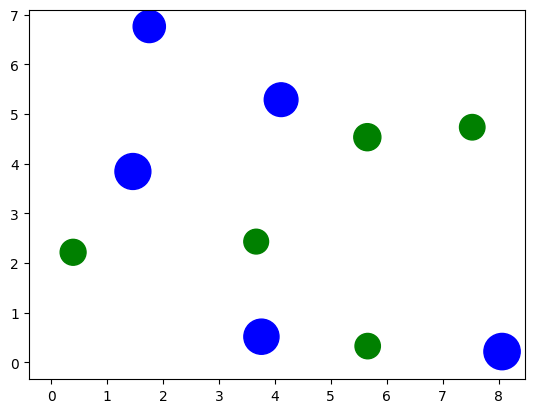

In [89]:
import matplotlib.pyplot as plt
plt.scatter(forager_set.agents.state.content['X'].reshape(-1), forager_set.agents.state.content['Y'].reshape(-1), color='blue', s=100*forager_set.agents.state.content['rad'].reshape(-1))
plt.scatter(resource_set.agents.state.content['X'].reshape(-1), resource_set.agents.state.content['Y'].reshape(-1), color='green', s=100*resource_set.agents.state.content['rad'].reshape(-1))
plt.show()

In [234]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_data = orbax_checkpointer.restore('./rec_data/'+str(num_recording_frames+rec_start_frame-1)+'/default')
rec_data = restored_data['rec_data']

In [242]:
def render_world(rec_data=None):
    upper_wall = 500
    lower_wall = 0
    right_wall = 2000
    left_wall = 0
    fig, ax = plt.subplots(figsize=(40,10))
    ax.set_xlim(left_wall-50, right_wall+50)
    ax.set_ylim(lower_wall-50, upper_wall+50)
    ax.set_aspect('equal')
    
    foragers_xs = rec_data['forager_xs'][0]
    foragers_ys = rec_data['forager_ys'][0]
    foragers_rads = rec_data['forager_rads'][0]
    foragers_angs = rec_data['forager_angs'][0]

    foragers_pos = ax.scatter(foragers_xs, foragers_ys, c='r', s=foragers_rads**2, alpha=0.5)
    foragers_dir = ax.quiver(foragers_xs, foragers_ys, 10*np.cos(foragers_angs), 10*np.sin(foragers_angs),
                            angles='xy', scale_units='xy', scale=1, color='g')

    resources_xs = rec_data['resource_xs'][0]
    resources_ys = rec_data['resource_ys'][0]
    resources_rads = rec_data['resource_rads'][0]
    resources_blossoms = rec_data['resource_blossoms'][0]
    resources_colors = ['b' if blossom else 'y' for blossom in resources_blossoms]
    resources_pos = ax.scatter(resources_xs, resources_ys, c=resources_colors, s=resources_rads**2, alpha=0.5)
    ax.axvline(x=left_wall, color='k', linestyle='--')
    ax.axvline(x=right_wall, color='k', linestyle='--')
    # draw a line at y=50, 550
    ax.axhline(y=lower_wall, color='k', linestyle='--')
    ax.axhline(y=upper_wall, color='k', linestyle='--')

    def render_update(step):
        foragers_pos.set_offsets(jnp.column_stack((rec_data['forager_xs'][step], rec_data['forager_ys'][step])))
        foragers_pos.set_sizes(rec_data['forager_rads'][step].reshape(-1)**2)
        foragers_dir.set_offsets(jnp.column_stack((rec_data['forager_xs'][step], rec_data['forager_ys'][step])))
        foragers_dir.set_UVC(10*np.cos(rec_data['forager_angs'][step]), 10*np.sin(rec_data['forager_angs'][step]))

        resources_pos.set_offsets(jnp.column_stack((rec_data['resource_xs'][step],rec_data['resource_ys'][step])))

        resources_pos.set_sizes(rec_data['resource_rads'][step].reshape(-1)**2)
        return resources_pos, foragers_pos, foragers_dir
    ani = animation.FuncAnimation(fig, render_update, frames=len(rec_data['forager_xs']), interval=100, blit=True)
    ani.save('./video/sim.mp4', writer='ffmpeg', fps=10)
    plt.close()
render_world(rec_data)